## 소개 ##

머신러닝을 연구하기 위해 진행하는 캐글 필사 프로젝트로 이 케글의 영감은 아래 글로부터 얻었습니다.

R을 빅데이터 분석 강의를 들을때 이후에는 만지지 않았는데 시간이 된다면 R로도 해보면 괜찮을 것 같습니다.

판다스의 기능 대부분이 R로부터 나온것이고 , RDBMS에서 제공하는 모든 쿼리문의 기능도 다 R에서 지원된다고 보면 됩니다.

["Exploring Survival on Titanic" by Megan Risdal, a Kernel in R on Kaggle][1]

I am going to try the following code on R tool as far as I could.

  [1]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

## 변수 설명 ##

* Survived: 생존 여부 => 0 = No, 1 = Yes
* pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
* Sex: 성별
* Age: 나이
* SibSp: 함께 탑승한 형제자매(Siblings), 배우자의 수(Spouse)
* Parch: 함께 탑승한 부모(Parents), 자식의 수(Children)
* Ticket: 티켓 번호
* Fare: 운임
* Cabin: 객실 번호
* Embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import numpy as np
import pandas as pd
import re as re
%matplotlib inline


# target directory for submission file
target_dir = '/kaggle/working/'

In [2]:
def load_dataset():
    """
    Load Dataset
    """
    train = pd.read_csv("../input/train.csv", header=0, dtype={"Age": np.float64})
    test  = pd.read_csv("../input/test.csv", header = 0,dtype={"Age": np.float64})
    
    full_data = [train, test]
    PassengerId = test["PassengerId"]
    return train, test, full_data, PassengerId

# revoked load_dataset()
train, test, full_data, PassengerId = load_dataset()

In [3]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

# 피처 엔지니어링 #

In [4]:
def get_suvival_ratio(df, selectList:None, groupbyCol:None):
    """
    집계 피처에 대해서 생존률을 리턴
    """
    display(df[selectList].groupby([groupbyCol], as_index=False).mean())

## 1. Pclass ##
널값이 존재하지 않으며,숫자형 타입

In [5]:
get_suvival_ratio(train, ["Pclass","Survived"], "Pclass")

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


## 2. Sex ##

In [6]:
#display(train[["Sex", "Survived"]].groupby(["Sex"]).mean())
get_suvival_ratio(train, ["Sex", "Survived"], "Sex")

,Sex,Survived
0,female,0.742038
1,male,0.188908


## 3. SibSp and Parch ##
SibSp - 자손 및 배우자, Parch - 아이들/부모님 - 이 두 피처를 이용해 가족의 규모를 유추해볼 수 있는 FamilySize피처를 생성

In [7]:
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
get_suvival_ratio(train, ["FamilySize", "Survived"], "FamilySize")

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


가족의 규모가 클수록 생존률이 떨어짐을 알 수 있다.

It seems that the family size feature has a meaningful effect on the survival ratio.

* 동반승객여부 피처 생성 - IsAlone

In [8]:
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"]==1, 'IsAlone'] = 1

#display(train[["IsAlone", "Survived"]].groupby(["IsAlone"], as_index=False).mean())    
get_suvival_ratio(train, ["IsAlone", "Survived"], "IsAlone")

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


IsAlone - 0(동행승객이 없는 경우) - 생존률이 그렇지 않은 경우보다 낮다.(의미있는 결과)

## 4. Embarked ##

In [9]:
display(train["Embarked"].value_counts())  # 70퍼센트 가까운 승객이 사우스햄튼발 승객
display(train["Embarked"].isnull().sum())

S    644
C    168
Q     77
Name: Embarked, dtype: int64

2

In [10]:
# 2개의 널값을 사우스햄튼으로 대치
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna('S')
    
get_suvival_ratio(train, ["Embarked", "Survived"], "Embarked")    

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


* 사우스햄튼 발 승객의 생존률이 프랑스 체르보르그(C) 및 뉴질랜드 퀸즈타운(Q) 항구에서 탑승한 승객의 생존률보다 낮음을 알수있다.

## 5. Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [11]:
display(train["Fare"].isnull().sum())
display(pd.cut(train["Fare"], 5))
display(pd.cut(train["Fare"], 5).value_counts())
display("NaN값 체크", train["Fare"].isna().sum())

0

0      (-0.512, 102.466]
1      (-0.512, 102.466]
2      (-0.512, 102.466]
3      (-0.512, 102.466]
4      (-0.512, 102.466]
             ...        
886    (-0.512, 102.466]
887    (-0.512, 102.466]
888    (-0.512, 102.466]
889    (-0.512, 102.466]
890    (-0.512, 102.466]
Name: Fare, Length: 891, dtype: category
Categories (5, interval[float64]): [(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (307.398, 409.863] < (409.863, 512.329]]

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

'NaN값 체크'

0

In [12]:
# replace nan into median
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
    
train["CategoricalFare"] = pd.cut(dataset["Fare"], 5)

In [13]:
get_suvival_ratio(train, ["CategoricalFare", "Survived"], "CategoricalFare")    

,CategoricalFare,Survived
0,"(-0.512, 102.466]",0.382429
1,"(102.466, 204.932]",0.461538
2,"(204.932, 307.398]",0.529412
3,"(307.398, 409.863]",NaN
4,"(409.863, 512.329]",0.000000


요금대가 384달러에서 512달러대의 승객은 전부 사망했고 또한 요금대가 128달러 이하인 승객들의 생존률도 높지 않다.

## 6. Age ##

결측치를 대치하기 위해 평균값과 표준편차를 이용해서 무작위의 값을 결측치 갯수만큼 생성해서 대치함.좋은 방법!!

Age피처의 범주형 숫자값으로 변환키위해 pd.cut()이용해 5개 범위로 분할

In [14]:
display("나이정보가 없는 승객 : ", train["Age"].isnull().sum())

'나이정보가 없는 승객 : '

177

In [15]:
for dataset in full_data:
    avg_age = dataset["Age"].mean()
    std_age = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    
    age_null_random_list = np.random.randint(avg_age - std_age, avg_age + std_age, age_null_count)
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
    
    
train["CategoricalAge"] = pd.cut(train["Age"], 5)    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
get_suvival_ratio(train, ["CategoricalAge", "Survived"], "CategoricalAge")   

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.522523
1,"(16.0, 32.0]",0.354839
2,"(32.0, 48.0]",0.372180
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


## 7. Name ##
이름으로 부터 존칭 정보를 추출

In [17]:
def get_title(name):
    """
    이름정보에서 해당 승객의 존칭정보를 가져오기
    """
    title  = ""
    title_search = re.search('([A-Za-z]+)\.', name)
    
    if title_search:
        title = title_search.group(1)
    return title

for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)
    
pd.DataFrame(pd.crosstab(index=train["Title"], columns=train["Sex"]))

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


 * Title피처의 범주형 피처로 변환 후 생존률 확인

In [18]:
stnd_title = ["Mr", "Miss", "Mrs", "Mlle", "Mme",]
train["Title"].value_counts().index.values

array(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Col', 'Major', 'Mlle',
       'Jonkheer', 'Lady', 'Mme', 'Countess', 'Capt', 'Ms', 'Don', 'Sir'],
      dtype=object)

In [19]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
get_suvival_ratio(train, ["Title", "Survived"], "Title")    

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


# Data Cleaning #
데이터정제 및 범주형 타입의 데이터를 숫자형으로 변환

In [20]:
display(train["CategoricalAge"].value_counts(), train["Age"].describe())

(16.0, 32.0]     434
(32.0, 48.0]     266
(-0.08, 16.0]    111
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: CategoricalAge, dtype: int64

count    891.000000
mean      29.718294
std       13.559038
min        0.000000
25%       21.000000
50%       29.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [21]:
train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [22]:
for dataset in full_data:
    # Mapping Sex
    dataset["Sex"] = dataset["Sex"].map({"female": 0 , "male": 1}).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare based on 1st quartile, 2nd quartile, 3rd quatile
    dataset.loc[dataset["Fare"] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 						        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch", "FamilySize"]
train = train.drop(drop_elements, axis = 1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis = 1)
test  = test.drop(drop_elements, axis = 1)

display (train.head(n=3))
display(test.head(n=3))

train = train.values
test  = test.values

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2


,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,3,1,2,0,2,1,1
1,3,0,2,0,0,0,3
2,2,1,3,1,2,1,1


# 분류기 비교 #

## 관련 라이브러리

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# StraifiedKFold와 ShuffleSplit의 결합
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 분류
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# 차원축소
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# 회귀
from sklearn.linear_model import LogisticRegression

* Modulization

In [24]:
def train_predict(X, y, classifiers: list):
    """
    학습 피처와 레이블 값을 인자로 받아서  정확도와 분류기별 정확도를 DataFrame으로 리턴
    """
    # StratifiedKFold와 ShuffleSplit의 기능을 갖고있음
    # 검증 인덱스와 학습인덱스를 나누어서 리턴함
    # 인자는 피처배열과 레이블 배열을 1차원 배열의 형태로 전달
    sss = StratifiedShuffleSplit(n_splits = 10, test_size = .3, random_state=0)
    
    accuracy = {}
    log_cols = ['Classifiers', 'Accuracy']
    log = pd.DataFrame(columns = log_cols)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for clf in classifiers:
            clf.fit(X_train, y_train)
            train_prediction = clf.predict(X_test)
            
            acc = accuracy_score(y_test, train_prediction)
            
            model = clf.__class__.__name__
            
            if model in accuracy:
                accuracy[model] += acc
            else:
                accuracy[model] = acc
                
    for k,  v in accuracy.items():
        accuracy[k] = accuracy[k] / 10.0
        log_entry = pd.DataFrame([[k, accuracy[k]]], columns = log_cols)
        log = log.append(log_entry)        
    display("최종결과", log)        
    return accuracy, log

def visualize_accuracy(log):
    """
    분류기별 정확도를 시각화(barplot)
    """
    plt.xlabel("Accuracy")
    plt.ylabel("Classifiers Accuracy")
    sns.set_color_codes("muted")
    
    sns.barplot(x="Accuracy", y = 'Classifiers', data = log, color='b')
def main_process(X, y, classifiers):
    accuracy, log = train_predict(X, y, classifiers)
    visualize_accuracy(log)

* REPL(Read Evaluate Print Loop)

'최종 결과 값 : '

,Classifiers,accuracy
0,KNeighborsClassifier,0.822222
0,SVC,0.790000
0,DecisionTreeClassifier,0.808889
0,RandomForestClassifier,0.818889
0,AdaBoostClassifier,0.806667
0,GradientBoostingClassifier,0.818889
0,GaussianNB,0.775556
0,LinearDiscriminantAnalysis,0.785556
0,QuadraticDiscriminantAnalysis,0.798889
0,LogisticRegression,0.797778


<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='accuracy', ylabel='Classifiers'>

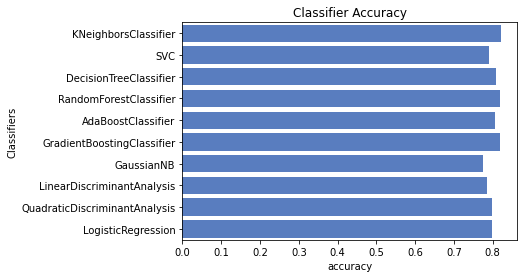

In [25]:
classifiers = [
    KNeighborsClassifier(n_neighbors = 5),
    SVC(C= 0.05, gamma='auto', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ['Classifiers', 'accuracy']
log = pd.DataFrame(columns = log_cols)

# StratifiedKFold와 ShuffleSplit의 기능을 갖고있음
# 검증 인덱스와 학습인덱스를 나누어서 리턴함
# 인자는 피처배열과 레이블 배열을 1차원 배열의 형태로 전달
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state = 0)

X = train[:, 1:]
y = train[:, 0]

accuracy = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        clf.fit(X_train, y_train)
        train_prediction = clf.predict(X_test)
        acc = accuracy_score(y_test, train_prediction)
        
        model = clf.__class__.__name__
        
        if model in accuracy:
            accuracy[model] += acc
        else:
            accuracy[model] = acc            
#display(accuracy)
for k, v in accuracy.items():
    accuracy[k] = accuracy[k] / 10.0
    log_entry = pd.DataFrame([[k, accuracy[k]]], columns=log_cols)
    log = log.append(log_entry)
    
display("최종 결과 값 : ", log)


# barplot으로 시각화
plt.xlabel("Accuracy")
plt.title("Classifier Accuracy")
sns.set_color_codes("muted")
sns.barplot(x='accuracy', y='Classifiers', data = log, color='b')

'최종결과'

,Classifiers,Accuracy
0,KNeighborsClassifier,0.801119
0,SVC,0.780224
0,DecisionTreeClassifier,0.798881
0,RandomForestClassifier,0.807836
0,AdaBoostClassifier,0.792164
0,GradientBoostingClassifier,0.809701
0,GaussianNB,0.769403
0,LinearDiscriminantAnalysis,0.789552
0,QuadraticDiscriminantAnalysis,0.803731
0,LogisticRegression,0.791045


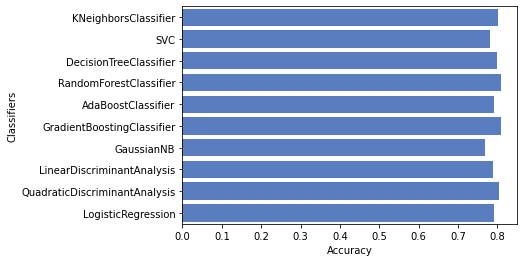

In [26]:
# 함수로 재작성 후 수행
main_process(X, y, classifiers)

# Prediction #
SVM를 최종 사용해서 학습 및 예측

In [27]:
final_clf = SVC()
final_clf.fit(X, y)

result = final_clf.predict(test)

final_submission = pd.DataFrame(data = {"PassengerId": PassengerId, "Survived": result})

display(final_submission.head(n=3))

final_submission.to_csv(target_dir + "titanic_survival_prediction.csv")

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [28]:
survivor_prediction = pd.read_csv(target_dir + "titanic_survival_prediction.csv")
display(survivor_prediction.head(n=3))
display(survivor_prediction.tail(n=3))

,Unnamed: 0,PassengerId,Survived
0,0,892,0
1,1,893,1
2,2,894,0


,Unnamed: 0,PassengerId,Survived
415,415,1307,0
416,416,1308,0
417,417,1309,0
